In [75]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [76]:
import numpy as np
import pandas as pd
import datetime as dt
import json
import os

# Reflect Tables into SQLAlchemy ORM

In [77]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [78]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [79]:
# reflect an existing database into a new model
Base = automap_base()


In [80]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [81]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [82]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [83]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [84]:
#columns of Measurement table
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
print('Columns of Measurement table:')
for column in columns:
    print(column['name'], column['type'])

#----
print('-----------------')

#columns of Station table
inspector = inspect(engine)
columns = inspector.get_columns('Station')
print('Columns of Station table:')
for column in columns:
    print(column['name'], column['type'])


Columns of Measurement table:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----------------
Columns of Station table:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [85]:
engine.execute("SELECT * FROM Measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [86]:
engine.execute("SELECT * FROM Station LIMIT 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Precipitation Analysis

In [87]:
# Find the most recent date in the data set. Could replace 'first' with 'all' to get all dates
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23')

In [88]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
one_year_ago



datetime.date(2016, 8, 23)

In [89]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()


In [90]:

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data_df = pd.DataFrame(prcp_data)

# Sort the dataframe by date
prcp_data_df.sort_values(by=["date"])
prcp_data_df



,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22
...,...,...
2218,2017-08-22,0.50
2219,2017-08-23,0.00
2220,2017-08-23,0.00
2221,2017-08-23,0.08


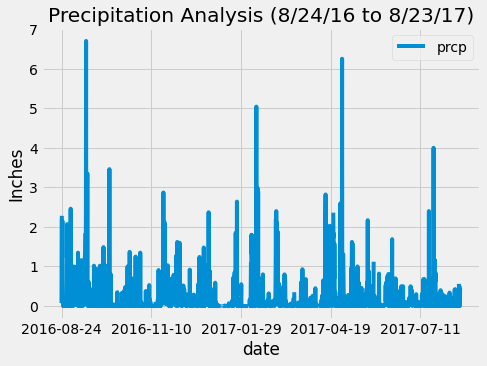

In [91]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_plt = prcp_data_df.plot(x = "date", figsize = (7,5))
prcp_plt.set_title("Precipitation Analysis (8/24/16 to 8/23/17)")
prcp_plt.set_ylabel('Inches')
plt.show()


In [92]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [93]:
# Design a query to calculate the total number stations in the dataset
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations available.".format(locations))

There are 9 stations available.


In [94]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                               group_by(Measurement.station).\
                               order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [95]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
result = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').order_by(func.min(Measurement.tobs)).all()
result

[(54.0, 85.0, 71.66378066378067)]

In [96]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp = session.query(Measurement.tobs).\
      filter(Measurement.date >= one_year_ago, Measurement.station == 'USC00519281').\
      order_by(Measurement.tobs).all()


In [97]:

tobs_df = pd.DataFrame(year_temp, columns=['Tobs'])
tobs_df.head()

,Tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


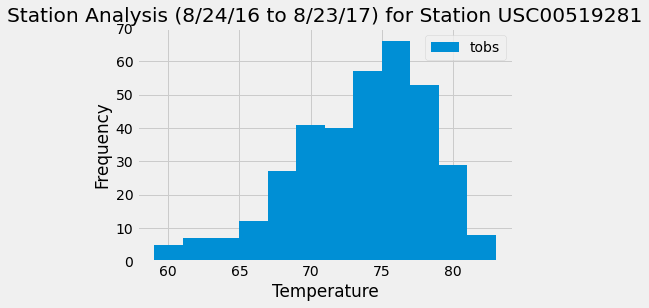

In [98]:

bins = 12
tobs_df.plot.hist(year_temp,bins)
plt.ylim(0,70)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station USC00519281")
plt.legend(["tobs"])
plt.show()

# Close session

In [99]:
# Close Session
session.close()